In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train = X_train.reshape((60000,28,28,1))
X_train = X_train.astype('float32')/255

X_test = X_test.reshape((10000,28,28,1))
X_test = X_test.astype('float32')/255

In [3]:
model = load_model('conv.h5')

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 2)         20        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 2)         38        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 2)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2

### Mamy 7 warst modelu. Dwie konwolucyjne, dwie maxpooling, dwie gęste i jedną spłaszczającą 

## Budowa modelu zwracającego przetworzone obrazy każdej z warstw

In [6]:
layer_outputs = [layer.output for layer in model.layers[:]]
layer_outputs

[<KerasTensor: shape=(None, 26, 26, 2) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 13, 13, 2) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 11, 11, 2) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 5, 5, 2) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_1')>]

In [7]:
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

In [8]:
activations = activation_model.predict(X_train[0].reshape(1,28,28,1))

1/1 [==============================] - 0s 235ms/step


### Wyniki pierwszej warstwy konwolucyjnej

In [9]:
first_layer_activation = activations[0]

In [10]:
first_layer_activation.shape

(1, 26, 26, 2)

### Wynik pierwszego filtra pierwszej warstwy konwolucyjnej

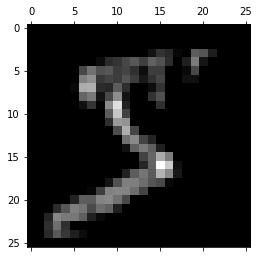

In [11]:
plt.matshow(first_layer_activation[0,:,:,0], cmap = 'gray')

### Wynik drugiego filtra pierwszej warstwy konwolucyjnej

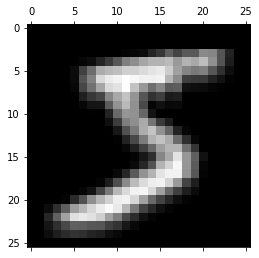

In [12]:
plt.matshow(first_layer_activation[0,:,:,1], cmap='gray')

In [13]:
first_layer_activation[0,:,:,1].shape

(26, 26)

## Przekształcenia inputu

In [14]:
layers_name = []

for layer in model.layers[:]:
    layers_name.append(layer.name)
    
layers_name

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dense_1']

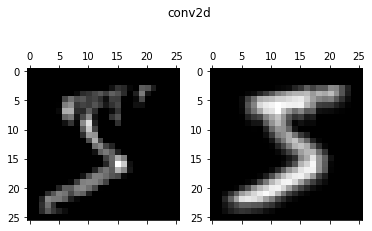

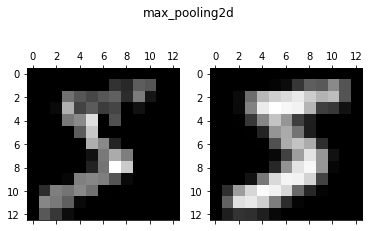

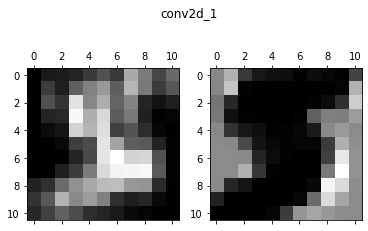

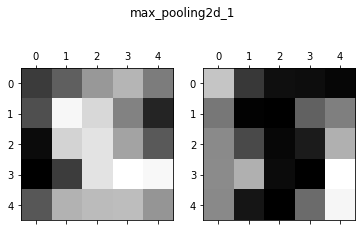

In [15]:
for i in range(4):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(str(layers_name[i]))
    ax1.matshow(activations[i][0,:,:,0], cmap='gray')
    ax2.matshow(activations[i][0,:,:,1], cmap='gray')

## Filtry konwolucyjne

In [16]:
conv_layers = list(filter(lambda x: 'conv' in x, layers_name))

conv_index = []

for i in range(len(layers_name)):
    if layers_name[i] in conv_layers:
        conv_index.append(i)

print(conv_layers)
print(conv_index)

['conv2d', 'conv2d_1']
[0, 2]


In [17]:
def conv_plot(n_layer):
    filters, biases = model.layers[n_layer].get_weights()
    dim_x = filters.shape[2]
    dim_y = filters.shape[3]
    
    fig, axs = plt.subplots(dim_x, dim_y)
    
    plt.suptitle(str(model.layers[n_layer].name))
    
    for i in range(dim_x):
        for j in range(dim_y):
            if dim_x == 1:
                axs[j].imshow(filters[:,:,:,j][:,:,i], cmap='gray')
                axs[j].set_xticks([])
                axs[j].set_yticks([])
            else:
                axs[i,j].imshow(filters[:,:,:,j][:,:,i], cmap='gray')
                axs[i,j].set_xticks([])
                axs[i,j].set_yticks([])

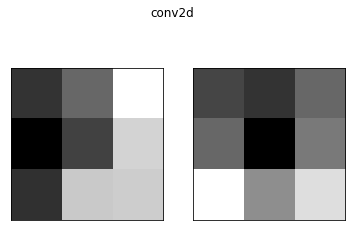

In [18]:
conv_plot(conv_index[0])

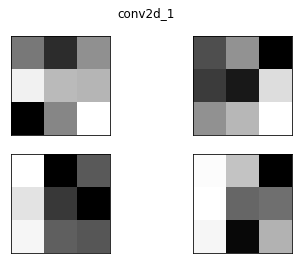

In [19]:
conv_plot(conv_index[1])

## Sprawdzenie wyników

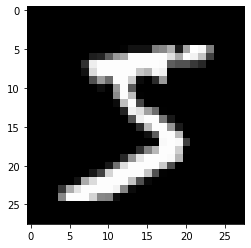

In [20]:
x = X_train[0].reshape(28,28)

plt.imshow(x, cmap='gray')

In [21]:
filters, biases = model.layers[conv_index[0]].get_weights()
kernel = filters[:,:,:, 0][:,:,0]

print(biases)

[-0.21284048  0.08991239]


In [22]:
def get_filter(n_layer, n, n_filter):
    filters = model.layers[n_layer].get_weights()[0]
    return filters[:,:,:,n][:,:,n_filter]

In [23]:
def get_bias(n_layer, n_bias):
    biases = model.layers[n_layer].get_weights()[1]
    return biases[n_bias]

In [24]:
f1 = get_filter(conv_index[0], 0, 0)
b1 = get_bias(conv_index[0], 0)

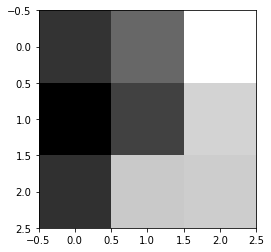

In [25]:
plt.imshow(f1, cmap='gray')

In [26]:
b1

-0.21284048

In [27]:
f2 = get_filter(conv_index[0], 1, 0)
b2 = get_bias(conv_index[0], 1)

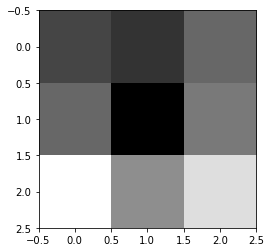

In [28]:
plt.imshow(f2, cmap='gray')

In [29]:
b2

0.08991239

### Funkcje wykonujące operacje warstwy konwolucyjnej (iloczyn splotowy)

In [30]:
def calc(img, kernel, a, b):
    s = 0
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            s += kernel[i][j] * img[a+i][b+j]
    return s

In [31]:
def conv(img, kernel, bias):
    output = []
    
    dim_x = img.shape[0] - kernel.shape[0] + 1
    dim_y = img.shape[1] - kernel.shape[1] + 1
    
    for i in range(dim_x):
        values = []
        
        for j in range(dim_y):
            value = calc(img, kernel, i, j) + bias
            print(value)
            values.append(value)
        output.append(values)
        
    return output

In [32]:
x_1 = conv(x, f1, b1)

-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827
-0.2128404825925827


In [33]:
x_2 = conv(x, f2, b2)

0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946
0.08991239219903946


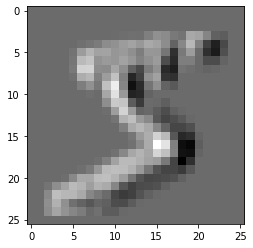

In [34]:
plt.imshow(x_1, cmap='gray')

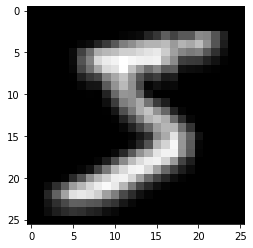

In [35]:
plt.imshow(x_2, cmap='gray')

### Funkcja aktywacji

\begin{equation}
  ReLu =
    \begin{cases}
      z_i & \text{$z_i$ => 0}\\
      0 & \text{$z_i$ < 0}\\
    \end{cases}       
\end{equation}

In [36]:
def relu(x):
    return np.maximum(x,0)

In [37]:
x_1 = relu(x_1)
x_2 = relu(x_2)

### Output pierwszej warstwy konwolucyjnej

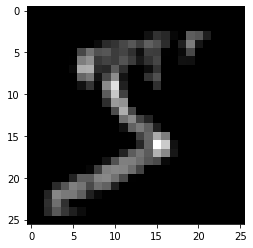

In [38]:
plt.imshow(x_1, cmap='gray')

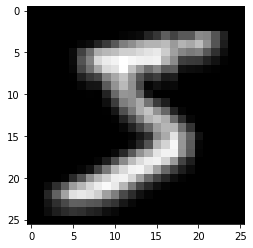

In [39]:
plt.imshow(x_2, cmap='gray')

### Funkcja MaxPooling2D

In [40]:
def get_values(img, a, b):
    values = []
    
    for i in range(2):
        for j in range(2):
            values.append(img[a+i][b+j])
            
    return values

In [41]:
import math

def maxpool(img):
    output = []
    
    dim_x = math.floor(((img.shape[0] - 2) / 2) + 1)
    dim_y = math.floor(((img.shape[1] - 2) / 2) + 1)
    
    for i in range(dim_x):
        max_values = []
        
        for j in range(dim_y):
            max_values.append(max(get_values(img, 2*i, 2*j)))
    
        output.append(max_values)
    
    return output

In [42]:
x_1 = maxpool(x_1)
x_2 = maxpool(x_2)

### Wynik pierwszej warstwy konwolucyjnej po operecji MaxPooling2D

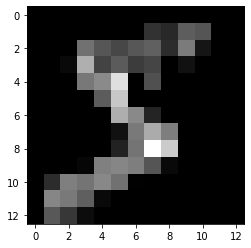

In [43]:
plt.imshow(x_1, cmap='gray')

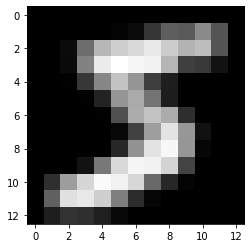

In [44]:
plt.imshow(x_2, cmap='gray')

# Przejście przez drugą warstwę konwolucyjną

In [45]:
x_1 = np.array(x_1)
x_2 = np.array(x_2)

In [46]:
x_1_f1 = get_filter(conv_index[1], 0, 0)
x_1_f2 = get_filter(conv_index[1], 1, 0)

x_2_f1 = get_filter(conv_index[1], 0, 1) 
x_2_f2 = get_filter(conv_index[1], 1, 1)

b1 = get_bias(conv_index[1], 0)
b2 = get_bias(conv_index[1], 1)

In [47]:
x_1_1 = np.array(conv(x_1, x_1_f1, 0))
x_2_1 = np.array(conv(x_2, x_2_f1, 0))

X_1 = x_1_1 + x_2_1 + b1

0.0
1.2147930083035052
1.5487171345751043
1.2138228190092222
1.3049341509383279
1.8750786206337162
1.6894651895077066
3.0732896236053433
2.6750402845024084
1.687774065151085
0.8536970413543893
0.09649306714181627
2.777173726309215
3.210497473685959
3.649068251790834
3.2166076516586557
3.47559371538878
2.655933175681552
3.2862355815539175
2.5264989608736608
2.0046265032611736
0.6310661838339899
0.06769744616712803
3.3426221870933452
4.79394076648613
7.20726061275367
4.094145288178099
3.7872921471795413
2.4504590607127854
2.0883643163420764
0.688191452525582
0.8148760938291066
0.10397675292893593
0.05354055139884917
1.9560149007158758
3.693816405537697
8.095898089214941
5.032960156559089
3.7574541116487836
1.0403711401575961
1.2533685451668986
0.029475289979906005
0.08514965357970805
0.0
0.0
0.7119838107209688
1.7161517544489728
6.219073984200842
5.951893442021871
4.67212614152836
0.30211931534400305
0.3852665092461486
0.0
0.0
0.0
0.0
0.0
0.5489755399086595
2.8385351691021183
4.563596815

In [48]:
x_1_2 = np.array(conv(x_1, x_1_f2, 0))
x_2_2 = np.array(conv(x_2, x_2_f2, 0))

X_2 = x_1_2 + x_2_2 + b2

0.0
1.009799359191531
1.4346691823328184
1.6307430331463229
1.5652349087054132
2.054197417599238
1.6069084751410896
2.4746730734846945
1.699165162691274
0.6556794105595317
0.15152886615714578
0.08021007422680793
2.457375416827878
2.2245799470971996
2.5032287082645364
2.0230288395410567
1.977647149641167
1.1337881523079474
1.4894759667088417
0.5085253761095339
0.6501234199338708
0.139730561369671
0.067167214302855
2.1611120117526754
2.6413937592692323
4.463499013697833
2.613206284489535
2.511120636039149
0.9278505018126469
0.6362338453701857
0.5461004816027224
0.2845410177681932
0.031102933131856636
-0.016205245203801733
0.6171383327799048
2.4066330439632235
4.3362500562765955
1.8744343946436421
1.8845327119848814
0.3266429420861219
0.12683089492585248
0.07510663358942526
0.02547111644562028
0.0
0.0
-0.2154978223500041
0.9578212929377881
3.335264599321231
3.321564498837588
2.1974484247817445
1.148328168847221
0.2728883906495839
0.0
0.0
0.0
0.0
0.0
-0.16615972384812783
1.498556260408201


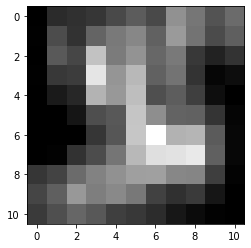

In [49]:
plt.imshow(X_1, cmap='gray')

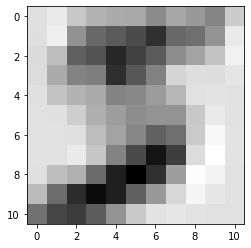

In [50]:
plt.imshow(X_2, cmap='gray')

### Funkcja aktywacji

$
\begin{equation}
\large sigmoid(z_i) = \frac{1}{1 + e^{z_i}}
\end{equation}
$

In [51]:
X_1 = tf.math.sigmoid(X_1)
X_2 = tf.math.sigmoid(X_2)

### Wynik drugiej warstwy konwolucyjnej

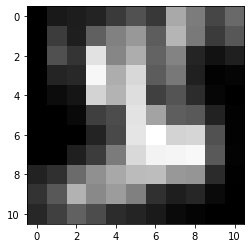

In [52]:
plt.imshow(X_1, cmap='gray')

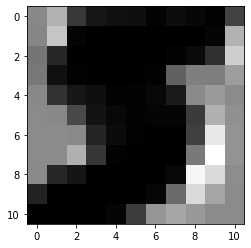

In [53]:
plt.imshow(X_2, cmap='gray')

### Wynik drugiej warstwy konwolucyjnej po operacji MaxPooling2D

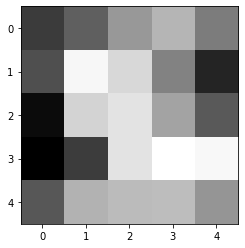

In [54]:
plt.imshow(maxpool(X_1), cmap='gray')

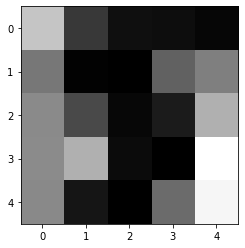

In [55]:
plt.imshow(maxpool(X_2), cmap='gray')